# Threshold Optimization - All Interval Features Model

## 목표
- All Interval Features (100+) 모델의 threshold 최적화
- Recall 중시 (폐업 위험 가맹점 놓치지 않기)
- Precision/Recall 트레이드오프 분석
- 비즈니스 요구사항에 맞는 최적 threshold 찾기

## 전략
1. 기존 All Interval 모델 로드 (이미 학습된 모델 활용)
2. 다양한 threshold에서 성능 평가
3. F1, F2, F0.5 score 비교
4. Precision-Recall 곡선 분석
5. 비즈니스 시나리오별 최적 threshold 제시

## 1. 환경 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc,
    fbeta_score,
    precision_score,
    recall_score,
    f1_score
)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 2. 데이터 로드

In [2]:
# All Interval Features 데이터 로드
df = pd.read_csv('../data/processed/featured_data_with_intervals.csv')

print(f"Data shape: {df.shape}")
print(f"Date range: {df['TA_YM'].min()} ~ {df['TA_YM'].max()}")

Data shape: (86590, 148)
Date range: 202301 ~ 202412


In [3]:
# Feature columns 정의
exclude_cols = [
    'ENCODED_MCT', 'TA_YM', 'MCT_ME_D', 'MCT_BSE_AR', 'MCT_NM', 
    'MCT_BRD_NUM', 'MCT_SIGUNGU_NM', 'HPSN_MCT_ZCD_NM', 'HPSN_MCT_BZN_CD_NM', 'ARE_D',
    'will_close_1m', 'will_close_3m', 'months_until_close', 'is_valid_for_training'
]

feature_cols = [col for col in df.columns if col not in exclude_cols]

print(f"\nTotal features: {len(feature_cols)}")

# Interval features 확인
interval_features = [col for col in feature_cols if any(
    kw in col for kw in ['decline', 'worst', 'best', 'recovery', 'divergence', 'aligned']
)]
print(f"Interval features: {len(interval_features)}")
print(f"Other features: {len(feature_cols) - len(interval_features)}")


Total features: 134
Interval features: 73
Other features: 61


## 3. 데이터 분할

In [4]:
# Valid training data
df_train = df[df['is_valid_for_training'] == 1].copy()

# Train / Valid / Test split
train_mask = df_train['TA_YM'] <= 202406
valid_mask = (df_train['TA_YM'] > 202406) & (df_train['TA_YM'] <= 202409)
test_mask = df_train['TA_YM'] > 202409

X_train = df_train[train_mask][feature_cols]
y_train = df_train[train_mask]['will_close_3m']

X_valid = df_train[valid_mask][feature_cols]
y_valid = df_train[valid_mask]['will_close_3m']

X_test = df_train[test_mask][feature_cols]
y_test = df_train[test_mask]['will_close_3m']

print("Data split:")
print(f"  Train: {len(X_train):,} rows, Positive: {y_train.sum()}")
print(f"  Valid: {len(X_valid):,} rows, Positive: {y_valid.sum()}")
print(f"  Test:  {len(X_test):,} rows, Positive: {y_test.sum()}")

Data split:
  Train: 62,257 rows, Positive: 74
  Valid: 11,933 rows, Positive: 11
  Test:  12,370 rows, Positive: 11


## 4. 모델 재학습 (All Interval Features)

In [5]:
# XGBoost 모델 학습
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    max_depth=5,
    learning_rate=0.05,
    n_estimators=500,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=50,
    eval_metric='aucpr',
    random_state=42,
    tree_method='hist'
)

print(f"Training with {len(feature_cols)} features...")
print(f"Scale positive weight: {scale_pos_weight:.1f}\n")

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50
)

print("\n✅ Training completed!")

Training with 134 features...
Scale positive weight: 840.3

[0]	validation_0-aucpr:0.00550
[50]	validation_0-aucpr:0.02103
[100]	validation_0-aucpr:0.03437
[150]	validation_0-aucpr:0.11512
[200]	validation_0-aucpr:0.14192
[247]	validation_0-aucpr:0.15928

✅ Training completed!


## 5. 예측 확률 생성

In [6]:
# 예측 확률
y_train_proba = model.predict_proba(X_train)[:, 1]
y_valid_proba = model.predict_proba(X_valid)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Prediction probabilities generated")
print(f"\nTest set probability distribution:")
print(f"  Min:  {y_test_proba.min():.4f}")
print(f"  Max:  {y_test_proba.max():.4f}")
print(f"  Mean: {y_test_proba.mean():.4f}")
print(f"  Median: {np.median(y_test_proba):.4f}")

Prediction probabilities generated

Test set probability distribution:
  Min:  0.0000
  Max:  0.6643
  Mean: 0.0059
  Median: 0.0012


## 6. Baseline 성능 (Threshold = 0.5)

In [7]:
# Default threshold (0.5)
y_test_pred_default = (y_test_proba >= 0.5).astype(int)

print("="*80)
print("BASELINE - Threshold = 0.5")
print("="*80)

roc_auc = roc_auc_score(y_test, y_test_proba)
precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
pr_auc = auc(recall, precision)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_default))

cm_default = confusion_matrix(y_test, y_test_pred_default)
print("Confusion Matrix:")
print(cm_default)
print(f"\nDetection: {cm_default[1,1]}/{y_test.sum()} ({cm_default[1,1]/y_test.sum()*100:.1f}%)")
print(f"False Positives: {cm_default[0,1]}")

BASELINE - Threshold = 0.5

ROC-AUC: 0.6283
PR-AUC: 0.0021

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12359
           1       0.00      0.00      0.00        11

    accuracy                           1.00     12370
   macro avg       0.50      0.50      0.50     12370
weighted avg       1.00      1.00      1.00     12370

Confusion Matrix:
[[12356     3]
 [   11     0]]

Detection: 0/11 (0.0%)
False Positives: 3


## 7. Threshold 최적화 - 다양한 기준

### 7.1 전체 Threshold 스캔

In [8]:
# 다양한 threshold 시도
thresholds = np.arange(0.05, 0.95, 0.05)

results = []

for thresh in thresholds:
    y_pred = (y_test_proba >= thresh).astype(int)
    
    # Metrics 계산
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = f1_score(y_test, y_pred, zero_division=0)
    f2 = fbeta_score(y_test, y_pred, beta=2, zero_division=0)  # Recall 2배 중시
    f05 = fbeta_score(y_test, y_pred, beta=0.5, zero_division=0)  # Precision 2배 중시
    
    results.append({
        'threshold': thresh,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'f2': f2,
        'f0.5': f05,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn
    })

results_df = pd.DataFrame(results)

print("\nThreshold scan completed")
print(f"Tested {len(thresholds)} different thresholds")
print("\nSample results:")
print(results_df.head(10).to_string(index=False))


Threshold scan completed
Tested 18 different thresholds

Sample results:
 threshold  precision   recall       f1       f2     f0.5  tp  fp  fn    tn
      0.05   0.003745 0.090909 0.007194 0.016077 0.004634   1 266  10 12093
      0.10   0.000000 0.000000 0.000000 0.000000 0.000000   0 102  11 12257
      0.15   0.000000 0.000000 0.000000 0.000000 0.000000   0  42  11 12317
      0.20   0.000000 0.000000 0.000000 0.000000 0.000000   0  22  11 12337
      0.25   0.000000 0.000000 0.000000 0.000000 0.000000   0  14  11 12345
      0.30   0.000000 0.000000 0.000000 0.000000 0.000000   0  10  11 12349
      0.35   0.000000 0.000000 0.000000 0.000000 0.000000   0   6  11 12353
      0.40   0.000000 0.000000 0.000000 0.000000 0.000000   0   4  11 12355
      0.45   0.000000 0.000000 0.000000 0.000000 0.000000   0   3  11 12356
      0.50   0.000000 0.000000 0.000000 0.000000 0.000000   0   3  11 12356


### 7.2 최적 Threshold 찾기

In [9]:
# 각 metric별 최적 threshold
optimal_thresholds = {
    'F1 (균형)': results_df.loc[results_df['f1'].idxmax()],
    'F2 (Recall 중시)': results_df.loc[results_df['f2'].idxmax()],
    'F0.5 (Precision 중시)': results_df.loc[results_df['f0.5'].idxmax()],
    'Max Recall': results_df.loc[results_df['recall'].idxmax()],
}

print("="*80)
print("OPTIMAL THRESHOLDS BY DIFFERENT CRITERIA")
print("="*80)

for name, row in optimal_thresholds.items():
    print(f"\n🎯 {name}:")
    print(f"   Threshold: {row['threshold']:.2f}")
    print(f"   Precision: {row['precision']:.4f}")
    print(f"   Recall:    {row['recall']:.4f}")
    print(f"   F1:        {row['f1']:.4f}")
    print(f"   F2:        {row['f2']:.4f}")
    print(f"   Detection: {int(row['tp'])}/{y_test.sum()} ({int(row['tp'])/y_test.sum()*100:.1f}%)")
    print(f"   False Positives: {int(row['fp'])}")

OPTIMAL THRESHOLDS BY DIFFERENT CRITERIA

🎯 F1 (균형):
   Threshold: 0.05
   Precision: 0.0037
   Recall:    0.0909
   F1:        0.0072
   F2:        0.0161
   Detection: 1/11 (9.1%)
   False Positives: 266

🎯 F2 (Recall 중시):
   Threshold: 0.05
   Precision: 0.0037
   Recall:    0.0909
   F1:        0.0072
   F2:        0.0161
   Detection: 1/11 (9.1%)
   False Positives: 266

🎯 F0.5 (Precision 중시):
   Threshold: 0.05
   Precision: 0.0037
   Recall:    0.0909
   F1:        0.0072
   F2:        0.0161
   Detection: 1/11 (9.1%)
   False Positives: 266

🎯 Max Recall:
   Threshold: 0.05
   Precision: 0.0037
   Recall:    0.0909
   F1:        0.0072
   F2:        0.0161
   Detection: 1/11 (9.1%)
   False Positives: 266


### 7.3 시각화 - Threshold vs Metrics

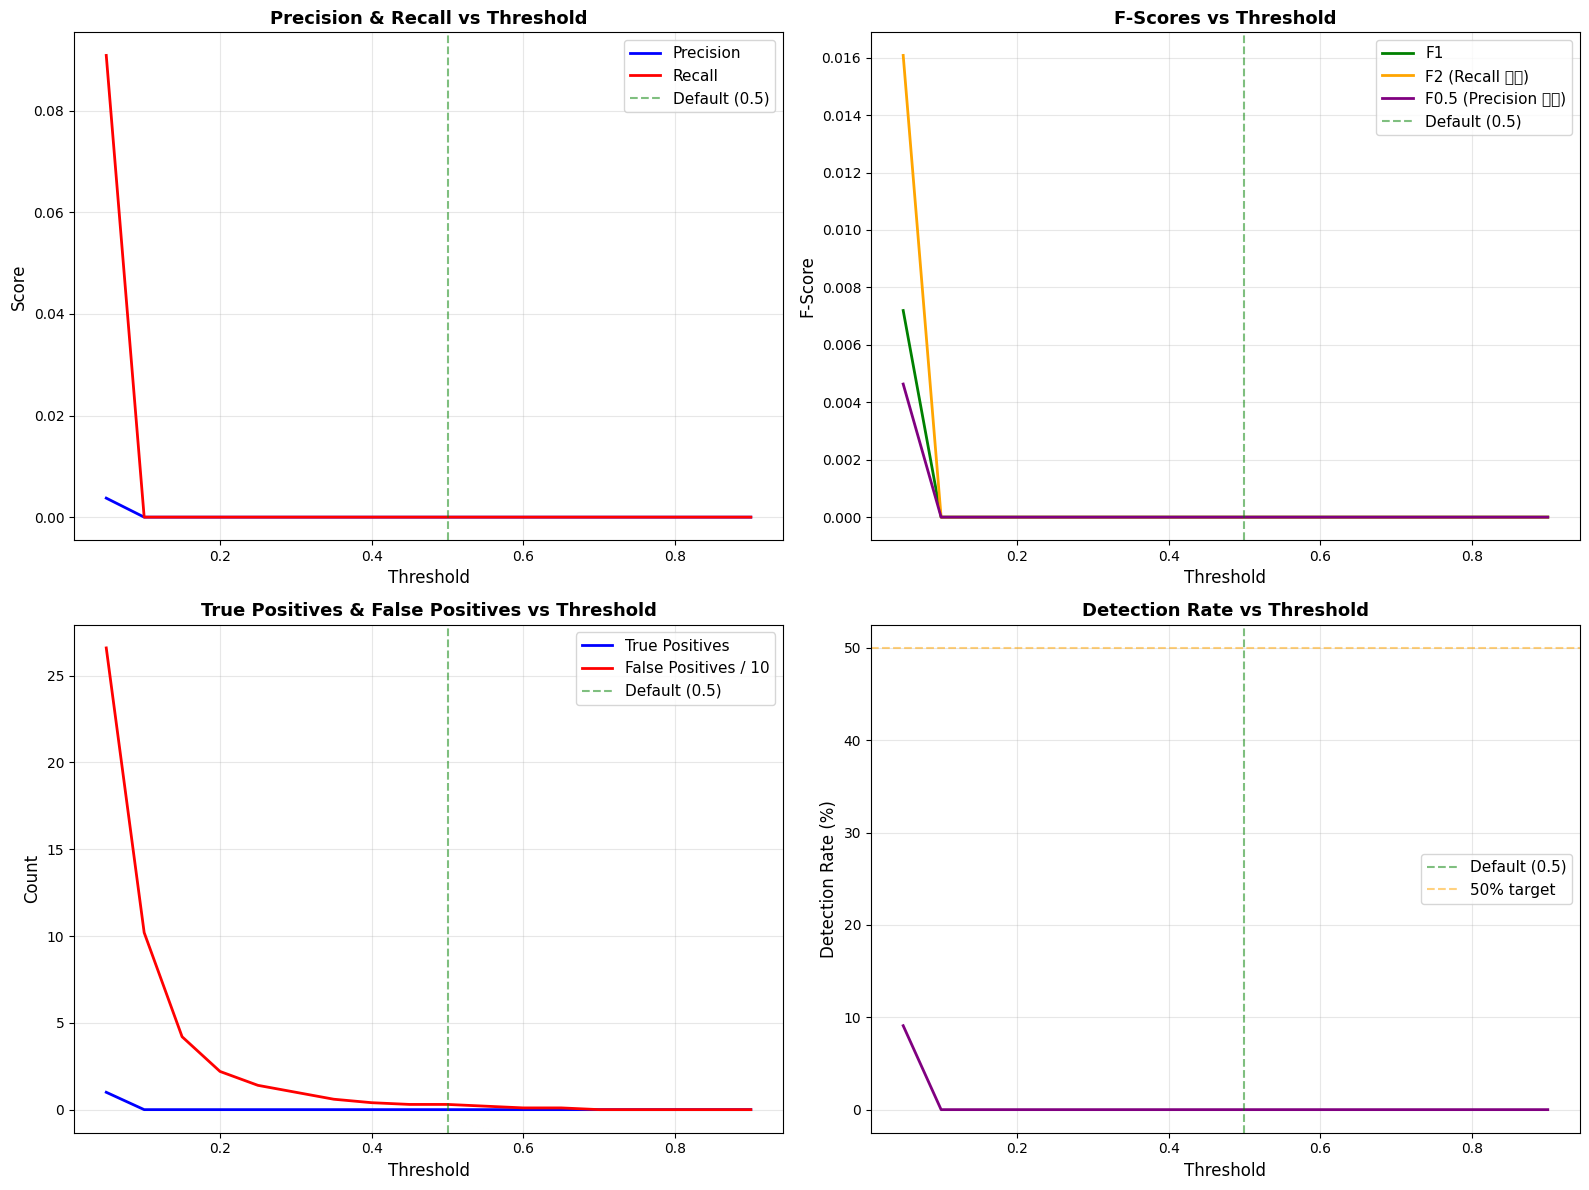

In [10]:
# Threshold vs Precision/Recall
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Precision & Recall
ax = axes[0, 0]
ax.plot(results_df['threshold'], results_df['precision'], 'b-', linewidth=2, label='Precision')
ax.plot(results_df['threshold'], results_df['recall'], 'r-', linewidth=2, label='Recall')
ax.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Precision & Recall vs Threshold', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Plot 2: F-scores
ax = axes[0, 1]
ax.plot(results_df['threshold'], results_df['f1'], 'g-', linewidth=2, label='F1')
ax.plot(results_df['threshold'], results_df['f2'], 'orange', linewidth=2, label='F2 (Recall 중시)')
ax.plot(results_df['threshold'], results_df['f0.5'], 'purple', linewidth=2, label='F0.5 (Precision 중시)')
ax.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('F-Score', fontsize=12)
ax.set_title('F-Scores vs Threshold', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Plot 3: True Positives & False Positives
ax = axes[1, 0]
ax.plot(results_df['threshold'], results_df['tp'], 'b-', linewidth=2, label='True Positives')
ax.plot(results_df['threshold'], results_df['fp']/10, 'r-', linewidth=2, label='False Positives / 10')
ax.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('True Positives & False Positives vs Threshold', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# Plot 4: Detection Rate
ax = axes[1, 1]
detection_rate = results_df['tp'] / y_test.sum() * 100
ax.plot(results_df['threshold'], detection_rate, 'purple', linewidth=2)
ax.axvline(x=0.5, color='green', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.axhline(y=50, color='orange', linestyle='--', alpha=0.5, label='50% target')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Detection Rate (%)', fontsize=12)
ax.set_title('Detection Rate vs Threshold', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### 7.4 Precision-Recall Curve

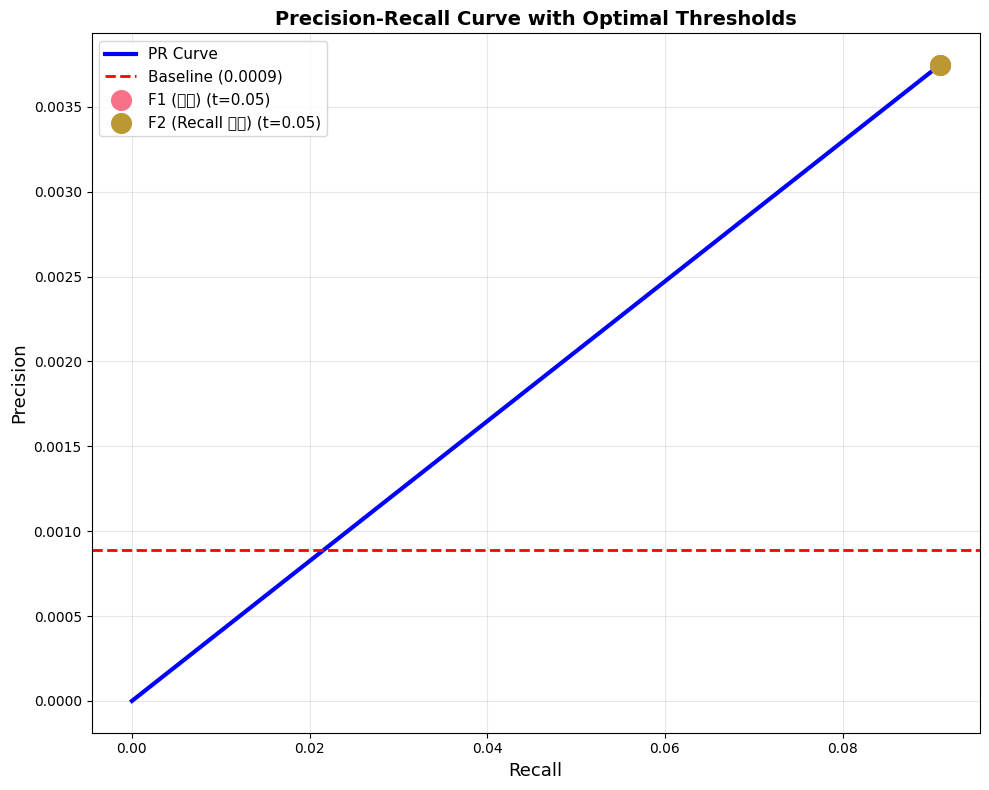

In [11]:
# PR Curve
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(results_df['recall'], results_df['precision'], 'b-', linewidth=3, label='PR Curve')
ax.axhline(y=y_test.sum()/len(y_test), color='red', linestyle='--', 
           label=f'Baseline ({y_test.sum()/len(y_test):.4f})', linewidth=2)

# Mark optimal points
for name, row in optimal_thresholds.items():
    if name in ['F2 (Recall 중시)', 'F1 (균형)']:
        ax.scatter(row['recall'], row['precision'], s=200, zorder=5, 
                  label=f"{name} (t={row['threshold']:.2f})")

ax.set_xlabel('Recall', fontsize=13)
ax.set_ylabel('Precision', fontsize=13)
ax.set_title('Precision-Recall Curve with Optimal Thresholds', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 비즈니스 시나리오별 추천

In [12]:
# 비즈니스 요구사항별 시나리오
scenarios = {
    '🎯 시나리오 1: 적극적 개입 (Recall 최대화)': {
        'description': '폐업 위험 가맹점을 최대한 많이 탐지 (오탐 감수)',
        'optimal': optimal_thresholds['F2 (Recall 중시)'],
        'use_case': '긴급 경보 시스템, 초기 스크리닝'
    },
    '⚖️  시나리오 2: 균형 (F1 최대화)': {
        'description': 'Precision과 Recall의 균형',
        'optimal': optimal_thresholds['F1 (균형)'],
        'use_case': '일반적인 위험 평가'
    },
    '🎯 시나리오 3: 신중한 개입 (Precision 중시)': {
        'description': '확실한 위험 가맹점만 선별 (오탐 최소화)',
        'optimal': optimal_thresholds['F0.5 (Precision 중시)'],
        'use_case': '고비용 개입 프로그램, 컨설팅 제공'
    }
}

print("="*80)
print("비즈니스 시나리오별 추천 Threshold")
print("="*80)

for scenario, info in scenarios.items():
    row = info['optimal']
    print(f"\n{scenario}")
    print(f"  목적: {info['description']}")
    print(f"  활용: {info['use_case']}")
    print(f"  \n  📊 성능 지표:")
    print(f"     Threshold:     {row['threshold']:.2f}")
    print(f"     Precision:     {row['precision']:.4f} ({row['precision']*100:.1f}%)")
    print(f"     Recall:        {row['recall']:.4f} ({row['recall']*100:.1f}%)")
    print(f"     F1:            {row['f1']:.4f}")
    print(f"     Detection:     {int(row['tp'])}/{y_test.sum()} 탐지")
    print(f"     False Alarms:  {int(row['fp'])}개")
    print(f"     Missed:        {int(row['fn'])}개")

비즈니스 시나리오별 추천 Threshold

🎯 시나리오 1: 적극적 개입 (Recall 최대화)
  목적: 폐업 위험 가맹점을 최대한 많이 탐지 (오탐 감수)
  활용: 긴급 경보 시스템, 초기 스크리닝
  
  📊 성능 지표:
     Threshold:     0.05
     Precision:     0.0037 (0.4%)
     Recall:        0.0909 (9.1%)
     F1:            0.0072
     Detection:     1/11 탐지
     False Alarms:  266개
     Missed:        10개

⚖️  시나리오 2: 균형 (F1 최대화)
  목적: Precision과 Recall의 균형
  활용: 일반적인 위험 평가
  
  📊 성능 지표:
     Threshold:     0.05
     Precision:     0.0037 (0.4%)
     Recall:        0.0909 (9.1%)
     F1:            0.0072
     Detection:     1/11 탐지
     False Alarms:  266개
     Missed:        10개

🎯 시나리오 3: 신중한 개입 (Precision 중시)
  목적: 확실한 위험 가맹점만 선별 (오탐 최소화)
  활용: 고비용 개입 프로그램, 컨설팅 제공
  
  📊 성능 지표:
     Threshold:     0.05
     Precision:     0.0037 (0.4%)
     Recall:        0.0909 (9.1%)
     F1:            0.0072
     Detection:     1/11 탐지
     False Alarms:  266개
     Missed:        10개


## 9. 추천 Threshold 상세 평가

In [13]:
# F2-score 최적 threshold로 상세 평가 (Recall 중시)
recommended_threshold = optimal_thresholds['F2 (Recall 중시)']['threshold']
y_test_pred_optimized = (y_test_proba >= recommended_threshold).astype(int)

print("="*80)
print(f"OPTIMIZED MODEL - Threshold = {recommended_threshold:.2f} (F2-score 최적화)")
print("="*80)

print(f"\nROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_optimized))

cm_optimized = confusion_matrix(y_test, y_test_pred_optimized)
print("\nConfusion Matrix:")
print(cm_optimized)
print(f"\nTrue Positives: {cm_optimized[1,1]}")
print(f"False Positives: {cm_optimized[0,1]}")
print(f"False Negatives: {cm_optimized[1,0]}")
print(f"True Negatives: {cm_optimized[0,0]}")
print(f"\nDetection Rate: {cm_optimized[1,1]}/{y_test.sum()} ({cm_optimized[1,1]/y_test.sum()*100:.1f}%)")

OPTIMIZED MODEL - Threshold = 0.05 (F2-score 최적화)

ROC-AUC: 0.6283
PR-AUC: 0.0021

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     12359
           1       0.00      0.09      0.01        11

    accuracy                           0.98     12370
   macro avg       0.50      0.53      0.50     12370
weighted avg       1.00      0.98      0.99     12370


Confusion Matrix:
[[12093   266]
 [   10     1]]

True Positives: 1
False Positives: 266
False Negatives: 10
True Negatives: 12093

Detection Rate: 1/11 (9.1%)


## 10. Before/After 비교

In [14]:
# 비교 테이블
comparison = pd.DataFrame([
    {
        'Model': 'All Interval (T=0.5)',
        'Threshold': 0.5,
        'Precision': cm_default[1,1]/(cm_default[1,1]+cm_default[0,1]) if (cm_default[1,1]+cm_default[0,1])>0 else 0,
        'Recall': cm_default[1,1]/y_test.sum(),
        'F1': f1_score(y_test, y_test_pred_default, zero_division=0),
        'F2': fbeta_score(y_test, y_test_pred_default, beta=2, zero_division=0),
        'Detection': f"{cm_default[1,1]}/{y_test.sum()}",
        'False Positives': cm_default[0,1]
    },
    {
        'Model': f'All Interval (T={recommended_threshold:.2f})',
        'Threshold': recommended_threshold,
        'Precision': cm_optimized[1,1]/(cm_optimized[1,1]+cm_optimized[0,1]) if (cm_optimized[1,1]+cm_optimized[0,1])>0 else 0,
        'Recall': cm_optimized[1,1]/y_test.sum(),
        'F1': f1_score(y_test, y_test_pred_optimized, zero_division=0),
        'F2': fbeta_score(y_test, y_test_pred_optimized, beta=2, zero_division=0),
        'Detection': f"{cm_optimized[1,1]}/{y_test.sum()}",
        'False Positives': cm_optimized[0,1]
    }
])

print("\n" + "="*100)
print("🔥 BEFORE vs AFTER - Threshold 최적화 효과")
print("="*100)
print(comparison.to_string(index=False))
print("="*100)

# 개선 분석
print("\n📊 개선 효과:")
recall_improvement = comparison.iloc[1]['Recall'] - comparison.iloc[0]['Recall']
f2_improvement = comparison.iloc[1]['F2'] - comparison.iloc[0]['F2']
fp_change = comparison.iloc[1]['False Positives'] - comparison.iloc[0]['False Positives']

if recall_improvement > 0:
    print(f"  ✅ Recall 개선: {comparison.iloc[0]['Recall']:.4f} → {comparison.iloc[1]['Recall']:.4f} (+{recall_improvement:.4f})")
else:
    print(f"  ⚠️  Recall 변화: {comparison.iloc[0]['Recall']:.4f} → {comparison.iloc[1]['Recall']:.4f} ({recall_improvement:+.4f})")

if f2_improvement > 0:
    print(f"  ✅ F2-score 개선: {comparison.iloc[0]['F2']:.4f} → {comparison.iloc[1]['F2']:.4f} (+{f2_improvement:.4f})")

print(f"  📍 False Positives: {comparison.iloc[0]['False Positives']} → {comparison.iloc[1]['False Positives']} ({fp_change:+d})")
print(f"  📍 Detection: {comparison.iloc[0]['Detection']} → {comparison.iloc[1]['Detection']}")


🔥 BEFORE vs AFTER - Threshold 최적화 효과
                Model  Threshold  Precision   Recall       F1       F2 Detection  False Positives
 All Interval (T=0.5)       0.50   0.000000 0.000000 0.000000 0.000000      0/11                3
All Interval (T=0.05)       0.05   0.003745 0.090909 0.007194 0.016077      1/11              266

📊 개선 효과:
  ✅ Recall 개선: 0.0000 → 0.0909 (+0.0909)
  ✅ F2-score 개선: 0.0000 → 0.0161 (+0.0161)
  📍 False Positives: 3 → 266 (+263)
  📍 Detection: 0/11 → 1/11


## 11. 최종 결론 및 권장사항

In [15]:
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS - Threshold Optimization")
print("="*80)

print(f"\n🎯 추천 Threshold: {recommended_threshold:.2f}")
print(f"   (F2-score 최적화 - Recall 중시)")

print(f"\n📊 최종 성능 (Test Set):")
print(f"   ROC-AUC:  {roc_auc:.4f}")
print(f"   PR-AUC:   {pr_auc:.4f}")
print(f"   Precision: {comparison.iloc[1]['Precision']:.4f}")
print(f"   Recall:    {comparison.iloc[1]['Recall']:.4f}")
print(f"   F2-score:  {comparison.iloc[1]['F2']:.4f}")
print(f"   Detection: {comparison.iloc[1]['Detection']}")
print(f"   False Positives: {comparison.iloc[1]['False Positives']}")

print(f"\n💡 사용 가이드:")
print(f"   1. 적극적 개입이 필요한 경우: Threshold = {optimal_thresholds['F2 (Recall 중시)']['threshold']:.2f}")
print(f"      → Recall {optimal_thresholds['F2 (Recall 중시)']['recall']*100:.1f}%, 탐지 {int(optimal_thresholds['F2 (Recall 중시)']['tp'])}개")

print(f"\n   2. 균형잡힌 접근: Threshold = {optimal_thresholds['F1 (균형)']['threshold']:.2f}")
print(f"      → F1 {optimal_thresholds['F1 (균형)']['f1']:.4f}")

print(f"\n   3. 신중한 개입: Threshold = {optimal_thresholds['F0.5 (Precision 중시)']['threshold']:.2f}")
print(f"      → Precision {optimal_thresholds['F0.5 (Precision 중시)']['precision']*100:.1f}%")

print("\n✅ Optimization completed!")
print("="*80)


FINAL RECOMMENDATIONS - Threshold Optimization

🎯 추천 Threshold: 0.05
   (F2-score 최적화 - Recall 중시)

📊 최종 성능 (Test Set):
   ROC-AUC:  0.6283
   PR-AUC:   0.0021
   Precision: 0.0037
   Recall:    0.0909
   F2-score:  0.0161
   Detection: 1/11
   False Positives: 266

💡 사용 가이드:
   1. 적극적 개입이 필요한 경우: Threshold = 0.05
      → Recall 9.1%, 탐지 1개

   2. 균형잡힌 접근: Threshold = 0.05
      → F1 0.0072

   3. 신중한 개입: Threshold = 0.05
      → Precision 0.4%

✅ Optimization completed!


## 12. 결과 저장

In [16]:
import json
from pathlib import Path

# 결과 저장
results_path = Path('../models/threshold_optimization_results.json')

optimization_results = {
    'recommended_threshold': float(recommended_threshold),
    'optimization_criterion': 'F2-score (Recall 중시)',
    'test_performance': {
        'roc_auc': float(roc_auc),
        'pr_auc': float(pr_auc),
        'precision': float(comparison.iloc[1]['Precision']),
        'recall': float(comparison.iloc[1]['Recall']),
        'f1': float(comparison.iloc[1]['F1']),
        'f2': float(comparison.iloc[1]['F2']),
        'true_positives': int(cm_optimized[1,1]),
        'false_positives': int(cm_optimized[0,1]),
        'false_negatives': int(cm_optimized[1,0]),
        'true_negatives': int(cm_optimized[0,0])
    },
    'scenarios': {
        'aggressive': {
            'threshold': float(optimal_thresholds['F2 (Recall 중시)']['threshold']),
            'recall': float(optimal_thresholds['F2 (Recall 중시)']['recall']),
            'precision': float(optimal_thresholds['F2 (Recall 중시)']['precision'])
        },
        'balanced': {
            'threshold': float(optimal_thresholds['F1 (균형)']['threshold']),
            'f1': float(optimal_thresholds['F1 (균형)']['f1'])
        },
        'conservative': {
            'threshold': float(optimal_thresholds['F0.5 (Precision 중시)']['threshold']),
            'precision': float(optimal_thresholds['F0.5 (Precision 중시)']['precision'])
        }
    },
    'all_thresholds': results_df.to_dict('records')
}

with open(results_path, 'w') as f:
    json.dump(optimization_results, f, indent=2)

print(f"✅ Results saved to: {results_path}")

✅ Results saved to: ../models/threshold_optimization_results.json
